## Exploring forecasting various home price metric with pytorch
see: 
- https://github.com/jdb78/pytorch-forecasting
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html 


In [1]:
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import dataset, network to train and metric to optimize
from pytorch_forecasting import (
    Baseline,
    TimeSeriesDataSet,
    TemporalFusionTransformer,
    QuantileLoss,
    RMSE,
    MAE,
    MAPE,
    MASE,
    SMAPE
)
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer, NaNLabelEncoder
import torch

# standard imports
import numpy as np
import pandas as pd
import datetime

#### Load Data

In [2]:
#use the pickle file for 2019 data instead
# data1 = pd.read_pickle("data/dataraw_to2018.pkl")
# data2 = pd.read_pickle("data/dataraw_2019.pkl")
# data = pd.concat([data1, data2], ignore_index=True)
data = pd.read_pickle("data/fulldataset.pkl")

In [3]:
print(data.shape)
data["year"] = pd.to_datetime(data["year"], format="%Y")

(15017, 80)


In [4]:
drop_cols = [
    "travel_time_to_work",
    "11_avg_annual_employee_pct_chg",
    "21_avg_annual_employee_pct_chg",
    "22_avg_annual_employee_pct_chg",
    "23_avg_annual_employee_pct_chg",
    "42_avg_annual_employee_pct_chg",
    "51_avg_annual_employee_pct_chg",
    "52_avg_annual_employee_pct_chg",
    "53_avg_annual_employee_pct_chg",
    "54_avg_annual_employee_pct_chg",
    "55_avg_annual_employee_pct_chg",
    "56_avg_annual_employee_pct_chg",
    "61_avg_annual_employee_pct_chg",
    "62_avg_annual_employee_pct_chg",
    "71_avg_annual_employee_pct_chg",
    "72_avg_annual_employee_pct_chg",
    "81_avg_annual_employee_pct_chg",
    "92_avg_annual_employee_pct_chg",
    "99_avg_annual_employee_pct_chg",
    "11_avg_annual_pay_pct_chg",
    "21_avg_annual_pay_pct_chg",
    "22_avg_annual_pay_pct_chg",
    "23_avg_annual_pay_pct_chg",
    "42_avg_annual_pay_pct_chg",
    "51_avg_annual_pay_pct_chg",
    "52_avg_annual_pay_pct_chg",
    "53_avg_annual_pay_pct_chg",
    "54_avg_annual_pay_pct_chg",
    "55_avg_annual_pay_pct_chg",
    "56_avg_annual_pay_pct_chg",
    "61_avg_annual_pay_pct_chg",
    "62_avg_annual_pay_pct_chg",
    "71_avg_annual_pay_pct_chg",
    "72_avg_annual_pay_pct_chg",
    "81_avg_annual_pay_pct_chg",
    "92_avg_annual_pay_pct_chg",
    "99_avg_annual_pay_pct_chg",
    "vehicles_per_person",
    "population",
    "household_income",
    "home_value_median",
    "birth_15_19_pct",
    "birth_20_24_pct",
    "birth_25_29_pct",
    "birth_30_34_pct",
    "birth_35_39_pct",
    "birth_40_44_pct",
    "birth_45_50_pct",
    "grade12_nodiploma_pct",
    "hs_diploma_pct",
    "some_college_lessthan_1yr_pct",
    "some_college_greaterthan_1yr_pct",
    "bachelor_degree_pct",
    "master_degree_pct",
    "professional_degree_pct",
    "doctorate_degree_pct",
    "occupied_units_pct",
    "vacant_units_pct",
    "median_ppsf",
    "annual_change_pct",
]

data = data.drop(columns=drop_cols)


In [5]:
#data = data.dropna() # try fill with 0
data = data.fillna(0)

In [6]:
data["time_idx"] = data["year"].dt.year # * 12 + data["year"].dt.month
data["time_idx"] -= data["time_idx"].min()
data["state_fips"] = data["state_fips"].astype("str").astype("category")
# data["income_tax_low"] = data["income_tax_low"].fillna(0)
# data["income_tax_high"] = data["income_tax_high"].fillna(0)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15017 entries, 0 to 15016
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   state_fips            15017 non-null  category      
 1   county_fips           15017 non-null  object        
 2   year                  15017 non-null  datetime64[ns]
 3   debt_ratio_low        15017 non-null  float64       
 4   debt_ratio_high       15017 non-null  float64       
 5   corp_income_tax_low   15017 non-null  float64       
 6   corp_income_tax_high  15017 non-null  float64       
 7   income_tax_low        15017 non-null  float64       
 8   income_tax_high       15017 non-null  float64       
 9   median_sale_price     15017 non-null  float64       
 10  median_list_price     15017 non-null  float64       
 11  median_list_ppsf      15017 non-null  float64       
 12  homes_sold            15017 non-null  float64       
 13  new_listings    

In [8]:
#data.columns
print(data.year.max())
data["time_idx"].unique()

2021-01-01 00:00:00


array([9, 6, 3, 2, 8, 4, 0, 5, 7, 1])

#### Create Dataset & Dataloaders

In [9]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 3
max_prediction_length = 1
training_cutoff = data["time_idx"].max() - max_prediction_length  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",  # column name of time of observation
    target="median_sale_price",  # column name of target to predict
    group_ids=["state_fips", "county_fips"],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=["state_fips", "county_fips"],
    static_reals=[],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=[],
    time_varying_known_reals=[
        "income_tax_low",
        "income_tax_high",
        "corp_income_tax_low",
        "corp_income_tax_high",
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "debt_ratio_low",
        "debt_ratio_high",
        "median_sale_price",
        "median_list_price",
        "median_list_ppsf",
        "homes_sold",
        "new_listings",
        "inventory",
        "months_of_supply",
        "median_dom",
        "avg_sale_to_list",
        "sold_above_list",
        "gdp",
    ],
    add_relative_time_idx=True,
    allow_missing_timesteps=True,
    categorical_encoders={"county_fips": NaNLabelEncoder(add_nan=True)},
    add_target_scales=True,
    add_encoder_length=True,
)
# target_normalizer=GroupNormalizer(
#     groups=["", ""], transformation="softplus"
# ),  # use softplus and normalize by group
# )


In [10]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    min_prediction_idx=training.index.time.max() + 1,
    stop_randomization=True,
)

In [11]:
# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=2 # double check factor of 10 will work
)

#### Baseline Model for comparison

In [12]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()
# baseline loss 59424.09375

59424.09375

#### Find Optimal Learning Rate

In [17]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergence
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=3,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 60.0k


Finding best initial lr: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


suggested learning rate: 0.12882495516931336


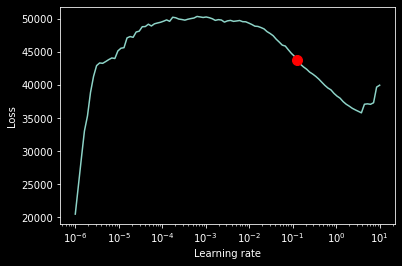

In [18]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Train Model

In [18]:
# configure network and trainer
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
# define network to train - the architecture is mostly inferred from the dataset,
# so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=82,
    lstm_layers=1, # Check to see if this helps, default is 1 - 2 didnt seem to to help 
    attention_head_size=1, # play around with this param - can go up to 4 depending on sizeof data 
    dropout=0.15,
    hidden_continuous_size=22,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=0,
    # optimizer parameters
    learning_rate=0.1, #change back to best_tft
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 638.5k


In [20]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 141 K 
3  | prescalers                         | ModuleDict                      | 924   
4  | static_variable_selection          | VariableSelectionNetwork        | 17.1 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 104 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 27.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 27.4 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 27.4 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 27.4

Epoch 18: 100%|██████████| 32/32 [06:12<00:00, 11.65s/it, loss=9.03e+03, v_num=2, train_loss_step=8.88e+3, val_loss=1.24e+4, train_loss_epoch=8.62e+3]  


#### Hyperparameter Tuning
- uses optuna: https://optuna.org/

In [12]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [13]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test_yearly",
    n_trials=30, 
    max_epochs=30,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128), # defaults were 8-128
    hidden_continuous_size_range=(8, 128), # defaults were 8-128
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.3),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

[I 2022-04-17 15:49:04,606] A new study created in memory with name: no-name-26334331-fbf2-471b-a8ed-811eee97a158
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2022-04-17 15:57:01,417] Trial 0 finished with value: 12561.6884765625 and parameters: {'gradient_clip_val': 0.22690526132985595, 'hidden_size': 53, 'dropout': 0.2262677389304312, 'hidden_continuous_size': 16, 'attention_head_size': 2, 'learning_rate': 0.020434435830250397}. Best is trial 0 with value: 12561.6884765625.
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/connect

In [14]:
# show best hyperparameters
print(study.best_trial.params)
# """{'
# gradient_clip_val': 0.959197055205936, 
# 'hidden_size': 24, 
# 'dropout': 0.1929539312539339, 
# 'hidden_continuous_size': 16, 
# 'attention_head_size': 2, 
# 'learning_rate': 0.10599457206520452}

# loss: 4673.2880859375 
# """

{'gradient_clip_val': 0.012136185295350904, 'hidden_size': 82, 'dropout': 0.14907256141821396, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.10036312732505494}


{'gradient_clip_val': 0.012136185295350904, 'hidden_size': 82, 'dropout': 0.14907256141821396, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.10036312732505494}

#### Evaluation

In [21]:
# # load the best model according to the validation loss
# # (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [22]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader) #change back to best_tft
(actuals - predictions).abs().mean().item() # MAE

41443.99609375

In [23]:
target = torch.flatten(actuals)
pred = torch.flatten(predictions)
base = torch.flatten(baseline_predictions)
#target.shape
#pred.shape

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("Model RMSE:", mean_squared_error(target, pred, squared=False)) #RMSE
# baseline RMSE 
print("Baseline RMSE", mean_squared_error(target, base, squared=False))

print("Model R2:", r2_score(target, pred))
print("Baseline R2:", r2_score(target, base))

Model RMSE: 98713.62
Baseline RMSE 113088.3
Model R2: 0.7294147505506086
Baseline R2: 0.6448716361468615


In [25]:
def results_df():
    """Transform tensors to results dataframe for charting."""
    preds_df = pd.DataFrame(predictions.numpy())
    targ_df = pd.DataFrame(actuals.numpy())
    idx_df = validation.decoded_index

    diff_df = targ_df - preds_df
    res = pd.concat([idx_df, diff_df], axis=1)
    
    return res

In [26]:
res_df = results_df()

In [30]:
#res_df.to_csv("yearly2021_pytorch_preds.csv")

In [21]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True) #change back to best_tft

In [35]:
#raw_predictions[0]

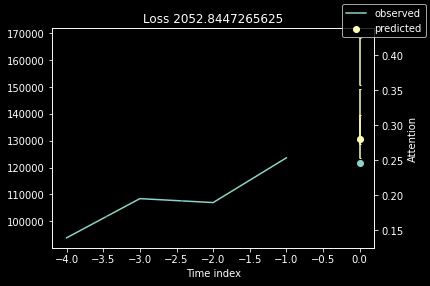

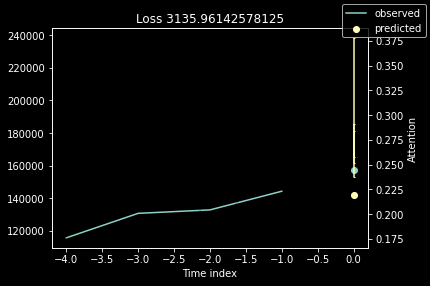

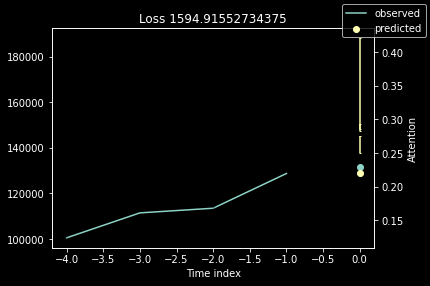

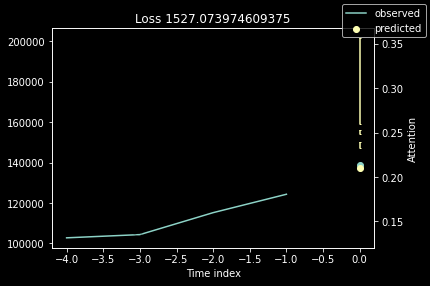

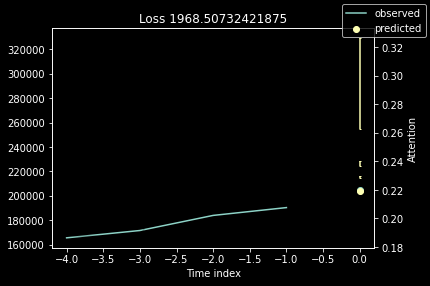

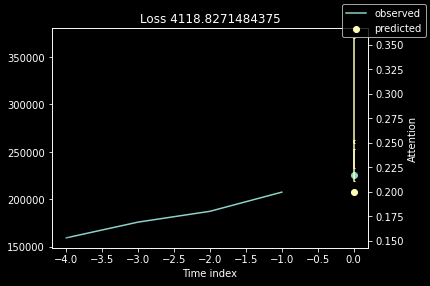

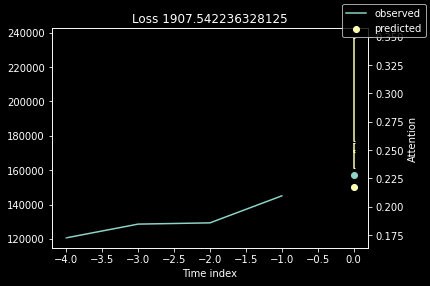

In [23]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True); #change back to best_tft

#### Worst Performers
- various metrics to choose from: https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.html#module-pytorch_forecasting.metrics

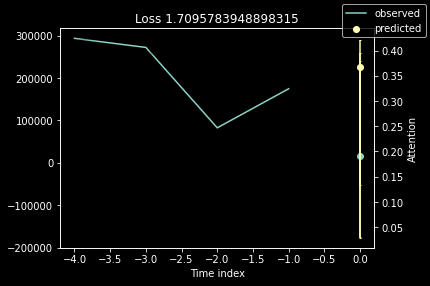

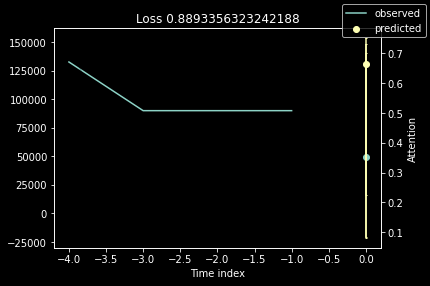

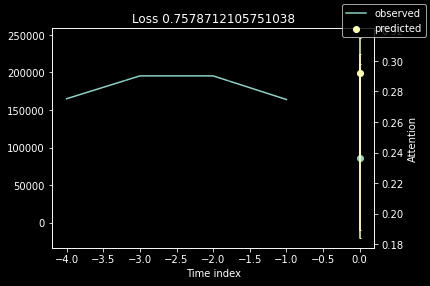

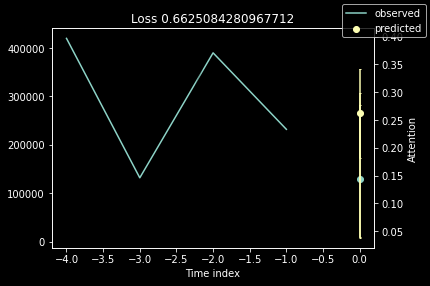

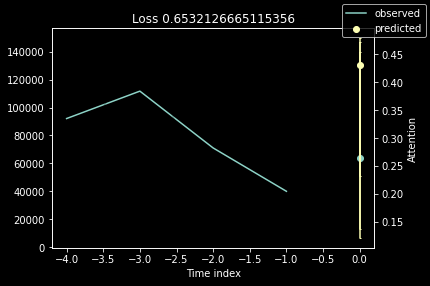

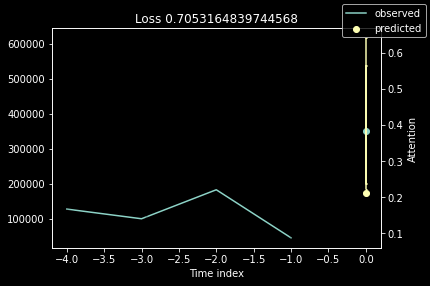

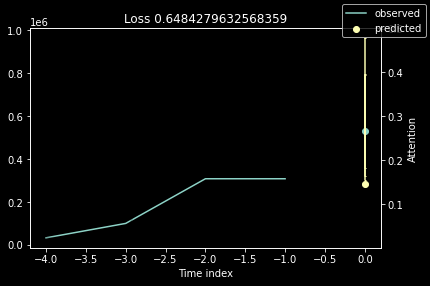

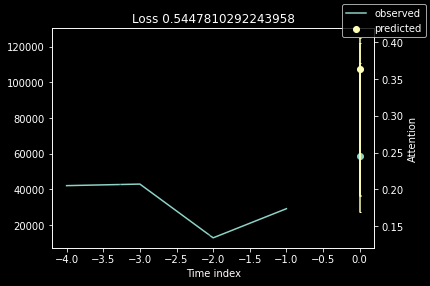

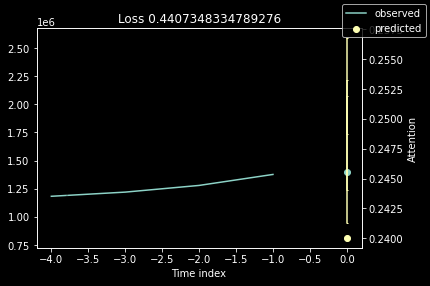

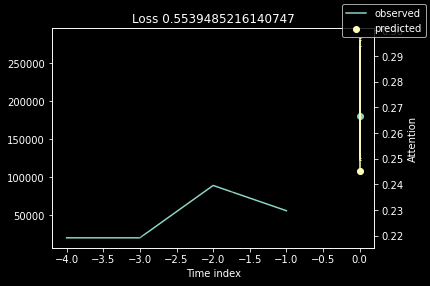

In [26]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

#### Actuals vs predictions by variable

In [29]:
# predictions, x = best_tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

#### Predict on selected data

In [ ]:
# change args to variables 
county = None
state = None
# fips = None

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

#### Model Interpretation

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x1314 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

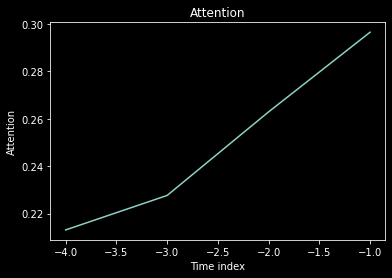

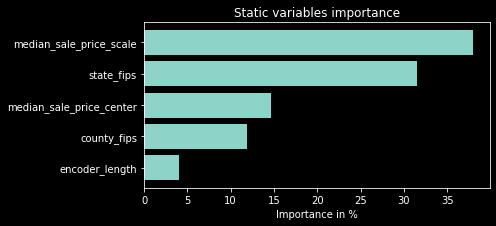

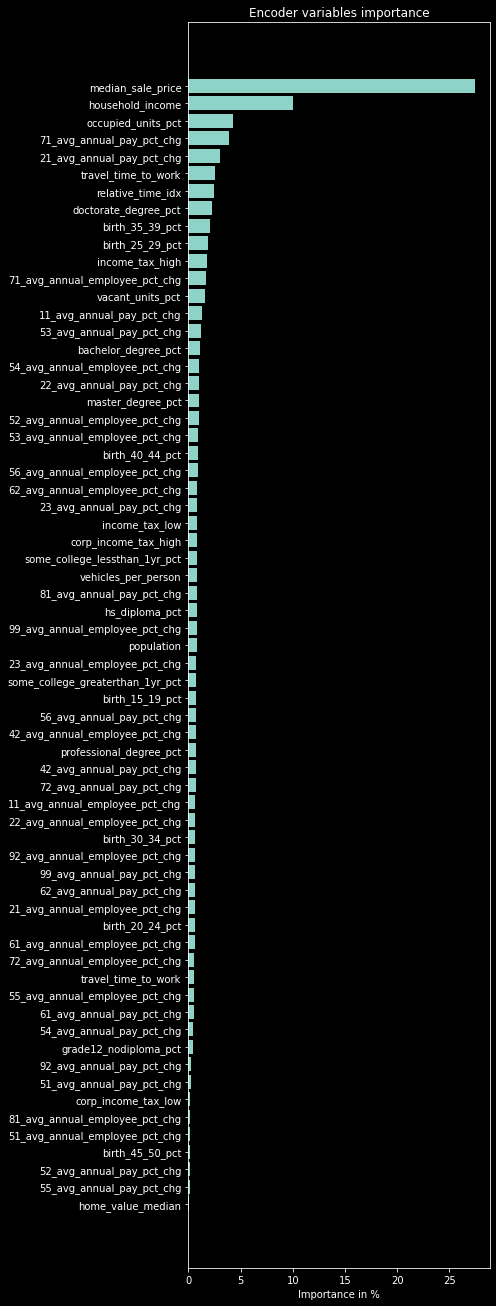

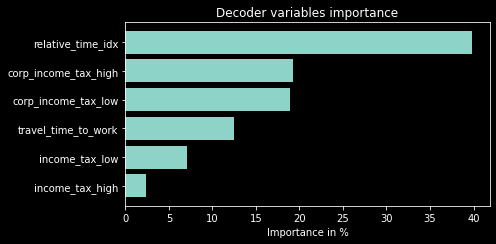

In [28]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
 # can look at partial dependency here later

#### RMSE